In [1]:
import mujoco
import mediapy as media
import mujoco.viewer as viewer
import pathlib
import matplotlib.pyplot as plt

libEGL warning: failed to open /dev/dri/renderD128: Permission denied

libEGL warning: failed to open /dev/dri/renderD128: Permission denied

libEGL warning: NEEDS EXTENSION: falling back to kms_swrast


In [3]:
model = mujoco.MjModel.from_xml_path('../build/mjpc/tasks/h1/walk/task.xml')
data = mujoco.MjData(model)
print("Model info:")
print(" nq", model.nq)
print(" nv", model.nv)
print(" nu", model.nu)
print(" na", model.na)
print(" njoint", model.njnt)

print("\nModel joints:")
for i in range(model.njnt):
    print(f" Joint {i}",model.joint(i).name, model.joint(i).type, model.joint(i).qposadr, model.joint(i).dofadr, model.joint(i).qpos0, model.joint(i).range)
    
print("\nModel bodies:")
for i in range(model.nbody):
    print("",model.body(i).name, i, model.body(i).pos)
    
print("\nModel sensors:")
for i in range(model.nsensor):
    print("",model.sensor(i).name, i, model.sensor(i).type, data.sensor(i).data)
    

Model info:
 nq 26
 nv 25
 nu 19
 na 0
 njoint 20

Model joints:
 Joint 0  [0] [0] [0] [0.   0.   1.06 1.   0.   0.   0.  ] [0. 0.]
 Joint 1 left_hip_yaw [3] [7] [6] [0.] [-0.43  0.43]
 Joint 2 left_hip_roll [3] [8] [7] [0.] [-0.43  0.43]
 Joint 3 left_hip_pitch [3] [9] [8] [0.] [-1.57  1.57]
 Joint 4 left_knee [3] [10] [9] [0.] [-0.26  2.05]
 Joint 5 left_ankle [3] [11] [10] [0.] [-0.87  0.52]
 Joint 6 right_hip_yaw [3] [12] [11] [0.] [-0.43  0.43]
 Joint 7 right_hip_roll [3] [13] [12] [0.] [-0.43  0.43]
 Joint 8 right_hip_pitch [3] [14] [13] [0.] [-1.57  1.57]
 Joint 9 right_knee [3] [15] [14] [0.] [-0.26  2.05]
 Joint 10 right_ankle [3] [16] [15] [0.] [-0.87  0.52]
 Joint 11 torso [3] [17] [16] [0.] [-2.35  2.35]
 Joint 12 left_shoulder_pitch [3] [18] [17] [0.] [-2.87  2.87]
 Joint 13 left_shoulder_roll [3] [19] [18] [0.] [-0.34  3.11]
 Joint 14 left_shoulder_yaw [3] [20] [19] [0.] [-1.3   4.45]
 Joint 15 left_elbow [3] [21] [20] [0.] [-1.25  2.61]
 Joint 16 right_shoulder_pitch [3]

In [5]:
data.sensor('foot_right_forward')

<_MjDataSensorViews
  data: array([0., 0., 0.])
  id: 29
  name: 'foot_right_forward'
>

In [ ]:
data.body('right_ankle_link')

In [ ]:
model.opt.timestep = 0.03

In [ ]:
geom = mujoco.MjvGeom()
start_pos = [0, 0, 0]
end_pos = [1, 1, 1]
width = 0.1
type = mujoco.mjtGeom.mjGEOM_LINE


In [ ]:
def add_fw_cost(manager):
    line = manager.add_line()
    line.start = lambda: data.site('upper_torso').xpos
    line.end = lambda: data.site('upper_torso').xpos + data.sensor('torso_forward').data
    line = manager.add_line()
    line.start = lambda: data.body('pelvis').xpos
    line.end = lambda: data.body('pelvis').xpos + data.sensor('pelvis_forward').data
    line = manager.add_line()
    line.start = lambda: data.body('right_ankle_link').xpos
    line.end = lambda: data.body('right_ankle_link').xpos + data.sensor('foot_right_forward').data
    line = manager.add_line()
    line.start = lambda: data.body('left_ankle_link').xpos
    line.end = lambda: data.body('left_ankle_link').xpos + data.sensor('foot_left_forward').data

In [ ]:
import time
import mujoco
import mujoco.viewer
from mjv_utils import Line, GeomManager

with mujoco.viewer.launch_passive(model, data) as viewer:
  start = time.time()
  while not viewer.is_running():
    pass
  viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = 1
  manager = GeomManager(viewer.user_scn)
  add_fw_cost(manager)
  while viewer.is_running():
    step_start = time.time()

    # mj_step can be replaced with code that also evaluates
    # a policy and applies a control signal before stepping the physics.
    mujoco.mj_step(model, data)
    manager.update()
    
    # Example modification of a viewer option: toggle contact points every two seconds.
    # with viewer.lock():
    #   viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = int(data.time % 2)
    
    # Pick up changes to the physics state, apply perturbations, update options from GUI.
    viewer.sync()

    # Rudimentary time keeping, will drift relative to wall clock.
    time_until_next_step = model.opt.timestep - (time.time() - step_start)
    
    if time_until_next_step > 0:
      time.sleep(time_until_next_step)
    else:
      print("Simulation not running in real time!")

In [ ]:
model = mujoco.MjModel.from_xml_path('./build/mjpc/tasks/humanoid/walk/task.xml')
data = mujoco.MjData(model)
viewer.launch(model=model, data=data)

In [ ]:
model = mujoco.MjModel.from_xml_path('./mjpc/tasks/h1/walk/task.xml')
data = mujoco.MjData(model)
viewer.launch(model=model, data=data)

# Trajectory interpolation testing

In [ ]:
import pathlib
import mujoco
from mujoco_mpc import agent as agent_lib
import time
import scipy
import scipy.interpolate

In [ ]:

model = mujoco.MjModel.from_xml_path('../build/mjpc/tasks/h1/walk/task.xml')
data = mujoco.MjData(model)

agent = agent_lib.Agent(task_id="H1 Walk", 
                            model=model, 
                            server_binary_path=pathlib.Path(agent_lib.__file__).parent
                            / "mjpc"
                            / "agent_server")

agent2 = agent_lib.Agent(task_id="H1 Walk", 
                            model=model, 
                            server_binary_path=pathlib.Path(agent_lib.__file__).parent
                            / "mjpc"
                            / "agent_server")

agent.set_state(
                time=data.time+1,
                qpos=data.qpos,
                qvel=data.qvel,
                act=data.act,
                mocap_pos=data.mocap_pos,
                mocap_quat=data.mocap_quat,
                userdata=data.userdata,
            )

agent2.set_state(
                time=data.time,
                qpos=data.qpos,
                qvel=data.qvel,
                act=data.act,
                mocap_pos=data.mocap_pos,
                mocap_quat=data.mocap_quat,
                userdata=data.userdata,
            )

In [ ]:
agent.get_cost_weights()

In [ ]:
t = time.time()
agent.planner_step()
agent2.planner_step()
print("Time", time.time()-t)

In [ ]:
t = time.time()
best_traj = agent.best_trajectory()
elapsed = time.time() - t
print(elapsed)
best_traj

In [ ]:
t = time.time()
agent.get_action(nominal_action=True, time=0.0000)
elapsed = time.time() - t
print(elapsed)

In [ ]:
print(len(best_traj['times']), len(best_traj['actions']), len(best_traj['states']))

In [ ]:
t = time.time()
a = scipy.interpolate.interp1d(best_traj['times'][:-1], best_traj['actions'], axis=0, kind='linear', fill_value='extrapolate')
elapsed = time.time() - t
print(elapsed)
t = time.time()
a(0.01)
elapsed = time.time() - t
print(elapsed)

In [ ]:
model_path = (
        "../build/mjpc/tasks/panda/task.xml"#"../build/mjpc/tasks/h1/walk/task.xml"
    )
model = mujoco.MjModel.from_xml_path(str(model_path))
data = mujoco.MjData(model)
mujoco.mj_resetData(model, data)
mujoco.mj_step(model, data)
width, height = (640, 480)
renderer = mujoco.Renderer(model)
renderer.update_scene(data)
fig = renderer.render()
plt.imshow(fig)


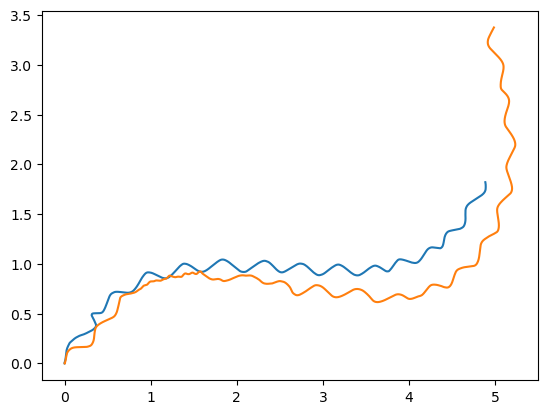

In [4]:
import numpy as np
import matplotlib.pyplot as plt
traj_det = np.load('traj_det.npy', allow_pickle=True)
traj_prob = np.load('traj_prob.npy', allow_pickle=True)
plt.plot(traj_det[:,1], traj_det[:,2])
plt.plot(traj_prob[:,1], traj_prob[:,2])

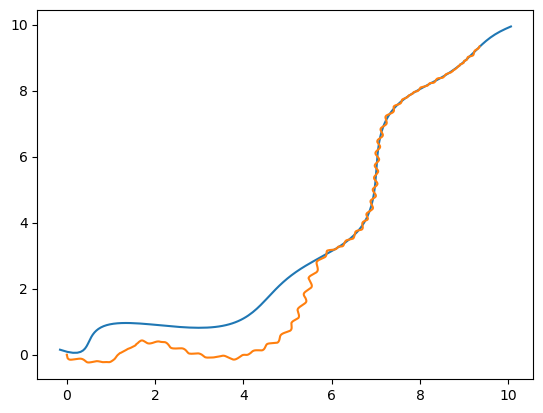

In [12]:
import matplotlib.pyplot as plt
import pickle
experiment_dir = "/home/antonio/uni/tesi/mujoco_mpc/experiments/relative_policy_combination/h1_walk_2024-09-11_09-34-34/"
traj_det = np.load(f'{experiment_dir}/traj.npy', allow_pickle=True)
reference_data = pickle.load(open(f'{experiment_dir}/path_data.pkl', 'rb'))
fit_x = reference_data['fit_x']
fit_y = reference_data['fit_y']
t = reference_data['t']
plt.plot(fit_x(t), fit_y(t))
plt.plot(traj_det[:,1], traj_det[:,2])

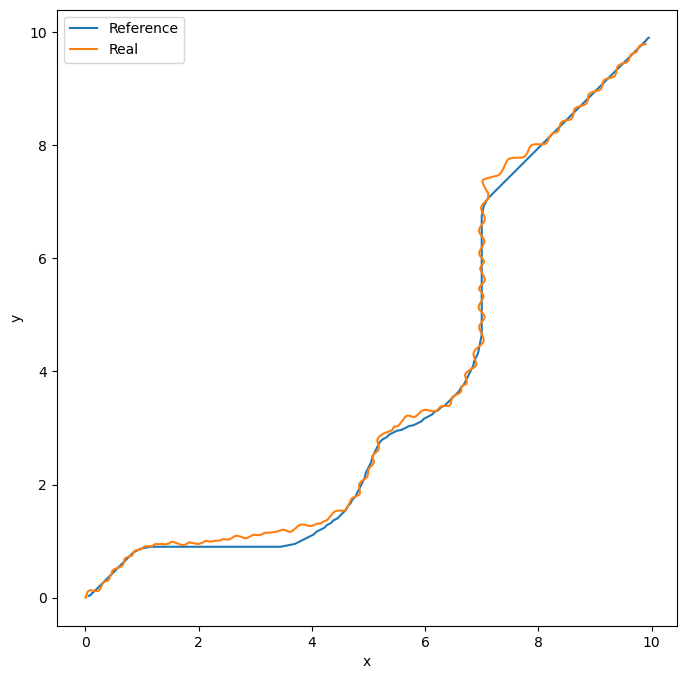

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
experiment_dir = "/home/antonio/uni/tesi/mujoco_mpc/experiments/relative_policy_combination/h1_walk_2024-09-12_10-06-05"
traj_det = np.load(f'{experiment_dir}/traj.npy', allow_pickle=True)
reference_data = pickle.load(open(f'{experiment_dir}/path_data.pkl', 'rb'))
path = reference_data['smoothed_path']
plt.figure(figsize=(8,8))
plt.plot(path[:,0], path[:,1])
plt.plot(traj_det[:,1], traj_det[:,2])
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Reference', 'Robot trajectory'])

## XY trajectory interpolation

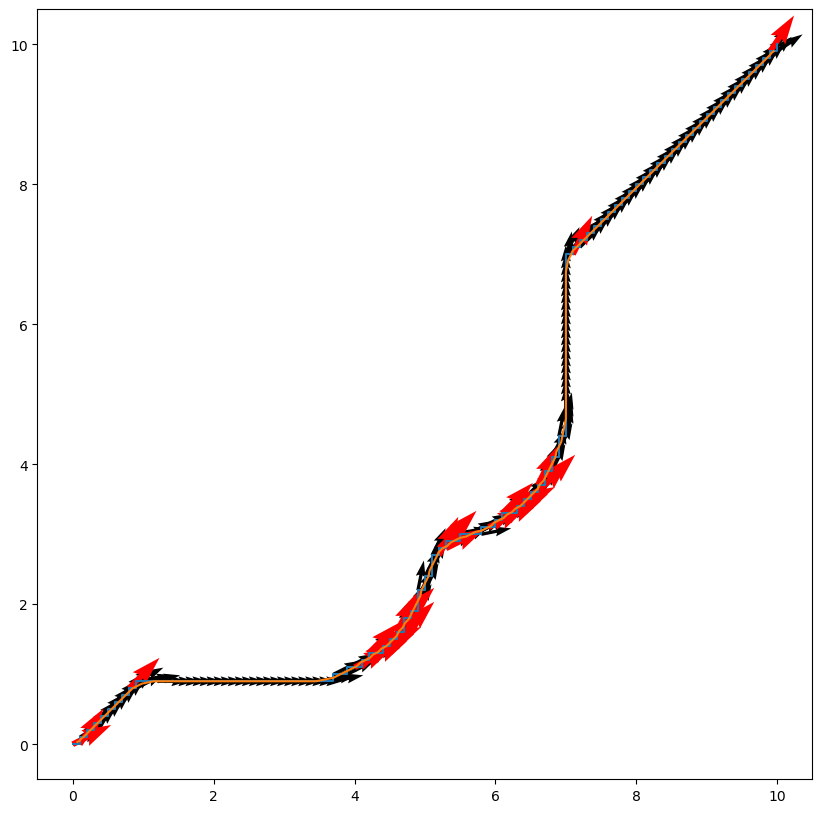

In [116]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

experiment_dir = "/home/antonio/uni/tesi/mujoco_mpc/experiments/relative_policy_combination/h1_walk_2024-09-11_09-34-34/"
reference_data = pickle.load(open(f'{experiment_dir}/path_data.pkl', 'rb'))
path = reference_data['path']

# ARMA filtering
filter_order = 3
smoothed_path = np.zeros_like(path)
for i,p in enumerate(path):
    smoothed_path[i] = np.mean(path[max(0, i-filter_order):min(i+filter_order, path.shape[0])], axis=0)

# Path tangents
path_diff = np.diff(smoothed_path, axis=0)
path_diff = path_diff / np.linalg.norm(path_diff, axis=1)[:,None]
critical_points = np.where(np.linalg.norm(np.diff(path_diff, axis=0), axis=1) > 0.3)

plt.figure(figsize=(10,10))
plt.plot(path[:,0], path[:,1])
plt.plot(smoothed_path[:,0], smoothed_path[:,1])
plt.quiver(path[:-1,0], path[:-1,1], path_diff[:,0], path_diff[:,1], scale_units='xy')
plt.quiver(path[critical_points,0], path[critical_points,1], path_diff[critical_points,0], path_diff[critical_points,1], color='r')

In [15]:
import pandas as pd

df = pd.read_csv('/home/antonio/uni/tesi/mujoco_mpc/experiments/h1_teleop_experiments/absolute_primitives_demo/data.csv')
fw = df[df['command']=="FORWARD"]['time']
sx = df[df['command']=="LEFT"]['time']
print(fw.idxmin()/10, fw.idxmax()/10, sx.idxmin()/10, sx.idxmax()/10)

47.2 427.0 457.7 799.9
